Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
#Load in the csv. 
import sys 
import pandas as pd
DATA_PATH = '../data/'
df = pd.read_csv(DATA_PATH+'/fatal-police-shootings-data.csv')
print(df.shape)
df.head()

(5408, 14)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [2]:
#Choose your target. For this, I want to see if I can predict Race.
target = 'race'
print(df['race'].value_counts())
print(df['race'].isnull())
df['race']
#This will be a Classification, there are 6 different races listed. 
#Baseline accuracy. White is the most common race, so its the baseline. 45.73% 
#Accuracy won't be quite good, probably be using Recall/Precision.
2473 / 5408

W    2473
B    1296
H     902
A      93
N      78
O      48
Name: race, dtype: int64
0       False
1       False
2       False
3       False
4       False
        ...  
5403     True
5404    False
5405    False
5406    False
5407    False
Name: race, Length: 5408, dtype: bool


0.4572855029585799

In [3]:
import numpy as np
def wrangle(X):
    X=X.copy()
    X['date'] = pd.to_datetime(X['date'], infer_datetime_format=True)
    cols_with_nans = ['armed','gender','race','flee']
    cols_for_age = ['age']
    for cols in cols_with_nans:
        X[cols] = X[cols].replace(np.nan, 'Unknown', inplace=True)
    mean = X['age'].dropna().sum() / len(X['age'])
    for cols in cols_for_age:
        X[cols] = X[cols].replace(np.nan, mean)
    return X, mean
wrangled, mean = wrangle(df)
type(wrangled)

pandas.core.frame.DataFrame

In [166]:
wrangled

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,5912,Jerry Bethel,2020-06-10,shot,gun,59.0,M,Unknown,Weippe,ID,False,attack,Unknown,False
5404,5913,Gregorio Cruz Vanloo,2020-06-11,shot,gun,28.0,M,W,DeKalb County,TN,False,attack,Other,False
5405,5914,Mason James Lira,2020-06-11,shot,gun,26.0,M,W,Paso Robles,CA,True,attack,Not fleeing,False
5406,5915,"Michael ""Blue"" Thomas",2020-06-11,shot,undetermined,62.0,M,B,Lancaster,CA,False,undetermined,Not fleeing,False


In [4]:
from sklearn.model_selection import train_test_split

base, test = train_test_split(wrangled, test_size=.15, random_state=1)
train, val = train_test_split(base, test_size=.2, random_state=1)
train.shape, val.shape, test.shape

((3676, 14), (920, 14), (812, 14))

In [5]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [6]:
columns_to_drop = ['id', 'name', 'race', 'date']
X_train = train.drop(columns=columns_to_drop, axis=1)
y_train = train[target]
X_val = val.drop(columns=columns_to_drop, axis=1)
y_val = val[target]
X_test = test.drop(columns=columns_to_drop, axis=1)
y_test = test[target]
X_train.shape, y_train.shape

((3676, 10), (3676,))

In [8]:
rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, min_samples_split=3, 
                             random_state=1, n_jobs=-1, oob_score=True, verbose=10)
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [12]:
X_train_encoded.head()

,manner_of_death,armed,age,gender,city,state,signs_of_mental_illness,threat_level,flee,body_camera
4160,1,1,26.0,1,1,1,False,1,1,False
7,1,2,35.0,2,2,2,False,1,1,False
572,1,2,49.0,2,3,3,False,1,1,False
360,1,2,18.0,2,4,4,True,1,1,False
1403,1,3,43.0,2,5,5,True,2,1,True


In [9]:
rfc.fit(X_train_encoded, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100

building tree 12 of 100
building tree 13 of 100building tree 14 of 100building tree 15 of 100


building tree 16 of 100building tree 17 of 100building tree 18 of 100
building tree 19 of 100

building tree 20 of 100

building tree 21 of 100building tree 22 of 100
building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100
building tree 28 of 100
building tree 29 of 100building tree 30 of 100

building tree 31 of 100building tree 32 of 100
building tree 33 of 100


building tree 34 of 100
building tree 35 of 100building tree 36 of 100

building tree 37 of 100
building tree 38 of 100
building tree 39 of 100building tree 40 of 100
building tree 41 of 100
building tree 42 of 100bui

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    0.2s


building tree 46 of 100building tree 47 of 100


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100building tree 54 of 100

building tree 55 of 100
building tree 56 of 100building tree 57 of 100building tree 58 of 100


building tree 59 of 100building tree 60 of 100

building tree 61 of 100
building tree 62 of 100building tree 63 of 100
building tree 64 of 100building tree 65 of 100building tree 66 of 100building tree 67 of 100

building tree 68 of 100
building tree 69 of 100

building tree 70 of 100

building tree 71 of 100
building tree 72 of 100

building tree 73 of 100building tree 74 of 100

building tree 75 of 100building tree 76 of 100building tree 77 of 100
building tree 78 of 100


building tree 79 of 100building tree 80 of 100
building tree 81 of 100

building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


building tree 86 of 100

building tree 87 of 100building tree 88 of 100building tree 89 of 100building tree 90 of 100building tree 91 of 100building tree 92 of 100




building tree 93 of 100building tree 94 of 100building tree 95 of 100



building tree 96 of 100
building tree 97 of 100building tree 98 of 100

building tree 99 of 100
building tree 100 of 100


RandomForestClassifier(min_samples_leaf=3, min_samples_split=3, n_jobs=-1,
                       oob_score=True, random_state=1, verbose=10)

In [10]:
print('Test Accuracy:', rfc.score(X_train_encoded, y_train))
print('Validation Accuracy:', rfc.score(X_val_encoded, y_val))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[P

Test Accuracy: 0.7543525571273123
Validation Accuracy: 0.48586956521739133


[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [13]:
from sklearn.inspection import permutation_importance
pi = permutation_importance(rfc, X_val_encoded, y_val, random_state=42, n_jobs=-1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [14]:
p_importance = pd.DataFrame({'feature': X_val_encoded.columns,
                            'weight': pi.importances_mean,
                            'std': pi.importances_std})
p_importance.sort_values('weight', ascending=False).head(10)

,feature,weight,std
5,state,0.069130,0.015024
2,age,0.059130,0.004044
6,signs_of_mental_illness,0.015435,0.002698
1,armed,0.001957,0.006048
7,threat_level,0.000435,0.004159
0,manner_of_death,-0.000870,0.000435
9,body_camera,-0.001957,0.002108
4,city,-0.002609,0.005439
3,gender,-0.002609,0.001108
8,flee,-0.003913,0.004792


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
pipe = make_pipeline(ce.OrdinalEncoder(),
                    SimpleImputer(strategy='median'),
                    GradientBoostingClassifier(n_estimators=100, random_state=1))
pipe.fit(X_train, y_train)
print('Train Accuracy:', pipe.score(X_train, y_train))
print('Validation Accuracy:', pipe.score(X_val, y_val))

Train Accuracy: 0.6488030467899891
Validation Accuracy: 0.5032608695652174


In [17]:
from xgboost import XGBClassifier
xgb = make_pipeline(ce.OrdinalEncoder(),
                   XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1))
xgb.fit(X_train, y_train)
print('Train accuracy:',xgb.score(X_train, y_train))
print('Validation Accuracy:', xgb.score(X_val, y_val))

Train accuracy: 0.5908596300326442
Validation Accuracy: 0.5141304347826087


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
print(xgb.named_steps['xgbclassifier'])
print(pipe.named_steps['gradientboostingclassifier'])
pipeline = make_pipeline(ce.OrdinalEncoder(),
                        RandomForestClassifier())
pipeline.fit(X_train, y_train)
param = {'randomforestclassifier__n_estimators': range(50,500),
        'randomforestclassifier__max_depth':[5,10,15,20,None],
        'randomforestclassifier__max_features':uniform(0,1),
        'randomforestclassifier__min_samples_leaf':[1,10,100],}
randomized_rfc = RandomizedSearchCV(pipeline, param_distributions= param,
                                   n_iter=50, cv=5, scoring='accuracy',
                                   verbose=10, return_train_score=True,
                                   n_jobs=-1)
randomized_rfc.fit(X_train, y_train)
print('Train accuracy for randomized:', randomized_rfc.score(X_train, y_train))
print('Validation Accuracy for Randomized:', randomized_rfc.score(X_val, y_val))

XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=1)
GradientBoostingClassifier(random_state=1)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Train accuracy for randomized: 0.750272034820457
Validation Accuracy for Randomized: 0.4815217391304348


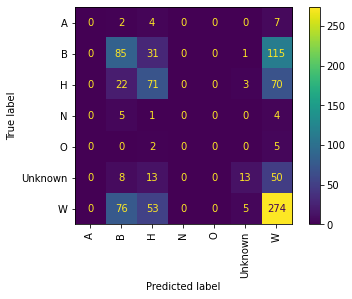

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(randomized_rfc, X_val, y_val, values_format='.0f',
                     xticks_rotation='vertical');

In [38]:
data = {'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA',
                 'KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
                 'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT',
                 'VA','WA','WV','WI','WY'],
       'H':[4.1,7.0,31.4,7.4,39.1,21.5,16.1,9.3,11.0,25.6,9.6,10.5,12.4,17.2,6.9,5.9,11.9,
            3.5,5.2,1.6,10.1,11.8,5.1,5.3,2.9,4.2,3.7,10.9,28.8,3.8,20.4,48.8,19.2,9.4,3.5,3.7,10.6,
           13.1,7.3,15.4,5.7,3.6,5.4,39.4,14.0,1.9,9.3,12.7,1.3,6.9,10.0],
       'W':[65.5,60.6,54.7,72.3,37.0,68.2,66.7,62.2,36.5,53.8,52.6,21.8,82.0,61.2,79.2,85.9,75.9,
           84.6,58.5,93.4,50.7,71.5,75.0,79.9,56.6,79.4,86.3,79.0,48.8,90.3,54.8,37.4,55.1,63.0,84.4,
           78.9,65.6,75.6,76.4,72.1,63.6,82.3,73.9,41.9,78.3,92.8,61.7,68.6,92.0,81.2,84.0],
       'B':[26.7,2.9,4.1,15.2,5.5,3.9,9.9,21.5,45.3,15.4,31.1,1.6,.6,14.0,9.2,3.3,5.5,8.0,32.1,1.2,
           29.4,7.0,13.6,6.4,37.9,11.4,.4,4.5,8.9,1.3,12.8,1.8,14.3,21.2,3.0,12.2,7.2,1.8,10.7,5.4,
           26.8,1.9,16.6,11.8,1.2,1.2,18.8,3.5,3.9,6.3,.9],
       'A':[1.3,6.6,3.2,1.6,14.4,3.1,4.5,4.0,4.0,2.8,3.9,37.3,1.3,5.4,2.2,2.6,2.9,1.4,1.8,1.1,6.4,6.6,
           3.1,4.9,.9,2.0,.7,2.4,8.3,2.7,9.8,1.3,8.7,2.9,1.7,2.2,2.1,4.3,3.5,3.6,1.5,1.2,1.8,4.8,2.4,
           1.8,6.4,8.5,.8,2.7,.8],
       'N':[.5,14.2,3.9,.6,.4,.6,.2,.2,.2,.2,.2,.1,1.1,.1,.1,.2,.6,.2,.5,.6,.2,.1,.5,1.0,.4,.3,5.9,.7,
           .9,.1,.1,8.8,.2,1.1,5.4,.2,7.3,.9,.1,.3,.2,8.6,.2,.3,1.0,.3,.2,1.0,.1,.8,2.1]}
racial_demographics = pd.DataFrame(data, columns=['state','H','W','B','A','N'])

In [ ]:
racial_demographics['O'] = 100 - (racial_demographics['H'] + racial_demographics['W'] + racial_demographics['B'] 
+ racial_demographics['A'] + racial_demographics['N'])
racial_demographics

In [66]:
racial_demographics

,state,H,W,B,A,N,O
0,AL,4.1,65.5,26.7,1.3,0.5,1.9
1,AK,7.0,60.6,2.9,6.6,14.2,8.7
2,AZ,31.4,54.7,4.1,3.2,3.9,2.7
3,AR,7.4,72.3,15.2,1.6,0.6,2.9
4,CA,39.1,37.0,5.5,14.4,0.4,3.6
5,CO,21.5,68.2,3.9,3.1,0.6,2.7
6,CT,16.1,66.7,9.9,4.5,0.2,2.6
7,DE,9.3,62.2,21.5,4.0,0.2,2.8
8,DC,11.0,36.5,45.3,4.0,0.2,3.0
9,FL,25.6,53.8,15.4,2.8,0.2,2.2


In [178]:
scratch_df = wrangled.copy()
scratch_df = pd.merge(scratch_df, racial_demographics,left_on='state',right_on='state', how='left')
print(scratch_df['race'].value_counts())
scratch_df

W          2473
B          1296
H           902
Unknown     518
A            93
N            78
O            48
Name: race, dtype: int64


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,H,W,B,A,N,O
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,12.7,68.6,3.5,8.5,1.0,5.7
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,13.1,75.6,1.8,4.3,0.9,4.3
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,11.9,75.9,5.5,2.9,0.6,3.2
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,39.1,37.0,5.5,14.4,0.4,3.6
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,21.5,68.2,3.9,3.1,0.6,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,5912,Jerry Bethel,2020-06-10,shot,gun,59.0,M,Unknown,Weippe,ID,False,attack,Unknown,False,12.4,82.0,0.6,1.3,1.1,2.6
5404,5913,Gregorio Cruz Vanloo,2020-06-11,shot,gun,28.0,M,W,DeKalb County,TN,False,attack,Other,False,5.4,73.9,16.6,1.8,0.2,2.1
5405,5914,Mason James Lira,2020-06-11,shot,gun,26.0,M,W,Paso Robles,CA,True,attack,Not fleeing,False,39.1,37.0,5.5,14.4,0.4,3.6
5406,5915,"Michael ""Blue"" Thomas",2020-06-11,shot,undetermined,62.0,M,B,Lancaster,CA,False,undetermined,Not fleeing,False,39.1,37.0,5.5,14.4,0.4,3.6


In [176]:
scratch_df['race'] = scratch_df['race'].replace('Unknown', 'W',inplace=True)

In [177]:
print(type(scratch_df))
print(scratch_df['race'].isnull().sum())
scratch_df['race']

<class 'pandas.core.frame.DataFrame'>
5408


0       None
1       None
2       None
3       None
4       None
        ... 
5403    None
5404    None
5405    None
5406    None
5407    None
Name: race, Length: 5408, dtype: object

In [173]:
def add_race(X):
    X=X.copy()
    race = X['race']
    X['demo'] = X[race]
    return X


In [174]:
test = add_race(scratch_df)
test

KeyError: "['Unknown'] not in index"